In [1]:
import numpy as np
import pandas as pd
from math import pi

# spot check on engineered-features
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data_raw():
    X = pd.read_csv('Data/X_train.csv')
    y = pd.read_csv('Data/y_train.csv')
    return (X, y)

def get_values_X_2D(X):
    n_timestep, n_feature = 128, 10
    X_data_ori = X.iloc[:,3:].values # original values
    #X_data = StandardScaler().fit_transform(X_data_ori)# standarlize the data
    #X_data = MinMaxScaler().fit_transform(X_data)# standarlize the data

    X_data_2D = np.reshape(X_data, (int(len(X_data)/n_timestep),n_timestep,n_feature)) # convert to 2D images
    return (X_data_2D)

def get_data(flatten = False): 
    # intend format, X = (n_example, n_timestep*n_features) when flatten is true
    # otherwise, X = (n_example, n_timestep, n_features)
    # y = surface name 
    X, y = load_data_raw()
    X_data = get_values_X_2D(X)
    if flatten == True:
        X_data = np.reshape(X_data, (np.shape(X_data)[0], np.shape(X_data)[1]*np.shape(X_data)[2]))

    y_data = y.surface
    print (np.shape(X_data))
    print (np.shape(y_data))
    return (X_data, y_data)

def conv_angles(x,y,z,w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)

    X = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    index_out = np.where(np.absolute(t2)>=1)# get the index which is out of range
    sign_out = np.sign(t2) # if out of range change it to pi/2 or -pi/2
    t2[index_out] = t2[index_out] *sign_out[index_out] 
    Y = np.arcsin(t2)
    

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = np.arctan2(t3, t4)
    

    return X, Y, Z
    
def conv_euler_angles(X_pd): # input is the panda dataframe of X
    n_timestep, n_feature = 128, 10
    X_data_ori = X_pd.iloc[:,3:].values # original values
    n_example = int(np.shape(X_data_ori)[0]/n_timestep)

    new_feature= np.zeros((n_example, n_timestep, 3))
    X = np.reshape(X_data_ori, (n_example, n_timestep, n_feature))
    for id_n in range(n_example):
        x = X[id_n,:,0] # x
        y = X[id_n,:,1] # y
        z = X[id_n,:,2] # z
        w = X[id_n,:,3] # w
        
        new_feature[id_n,:,0], new_feature[id_n,:,1], new_feature[id_n,:,2] = conv_angles(x,y,z,w) 

        
    new_feature_norm_1d= np.reshape(new_feature,(n_example*n_timestep, 3))
    #new_feature_norm_1d = StandardScaler().fit_transform(new_feature_norm_1d)# standarlize the data
    
    new_feature_norm_2d = np.reshape(new_feature_norm_1d,(n_example, n_timestep, 3))
    X_values_comb = np.concatenate((X, new_feature_norm_2d), axis=2)

    return(X_values_comb)


## Feature engineer: converting quaternion coordinates to Euler angles

In [4]:
X, y = load_data_raw()
X_data_comb = conv_euler_angles(X)#wrong because it has been normalized
y_data = y.surface

X['angle_X'] = X_data_comb[:,:,10].ravel()
X['angle_Y'] = X_data_comb[:,:,11].ravel()
X['angle_Z'] = X_data_comb[:,:,12].ravel()

X = X.drop(['row_id'], axis=1)

In [5]:
timeseries = X.copy()
timeseries.head()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,angle_X,angle_Y,angle_Z
0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,2.843272,-0.024668,1.396664
1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,2.843199,-0.024662,1.396646
2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,2.843224,-0.024728,1.396682
3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,2.843186,-0.024770,1.396721
4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,2.843195,-0.024784,1.396693


## Duplicate dataframe of hard_tiles (minority class)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

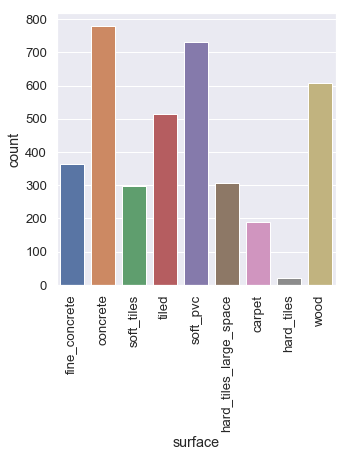

In [7]:
sns.set(style="whitegrid")
sns.set(font_scale=1.2)  
plt.figure(figsize=(5,5))
ax = sns.countplot(x="surface", data=y)
plt.xticks(rotation=90)

In [8]:
id_n = y[y.surface == 'hard_tiles'].series_id 
max_id = np.max(y.series_id)

In [10]:
X_minority = X.loc[X.series_id == 27]
print (np.shape(X_minority))
X_minority.series_id = max_id+1

(128, 15)


In [11]:
max_id = np.max(y.series_id)
max_id += 1
X_minority = X[X.series_id == 27]
X_minority.series_id = max_id # have to change the id number to create new entry
y_minority = y[y.series_id == 27]
y_minority.series_id = max_id
print (np.shape(X_minority))
print (np.shape(y_minority))

(128, 15)
(1, 3)


In [12]:
max_id = np.max(y.series_id)
max_id += 1
X_minority = X[X.series_id == 27]
X_minority.series_id = max_id # have to change the id number to create new entry
y_minority = y[y.series_id == 27]
y_minority.series_id = max_id

for i in range(10):
    for minority_id in id_n:
        X_minority_next = X[X.series_id == minority_id]
        y_minority_next = y[y.series_id == minority_id]
        max_id += 1
        X_minority_next.series_id = max_id
        y_minority_next.series_id = max_id

        X_minority = X_minority.append(X_minority_next)
        y_minority = y_minority.append(y_minority_next)

print (np.shape(X_minority))
print (np.shape(y_minority))
 

(27008, 15)
(211, 3)


In [13]:
timeseries = timeseries.append(X_minority)
y = y.append(y_minority)

In [14]:
y_timeseries = y.surface.reset_index().drop(['index'], axis=1)

In [15]:
y_timeseries.head()

,surface
0,fine_concrete
1,concrete
2,concrete
3,concrete
4,soft_tiles


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

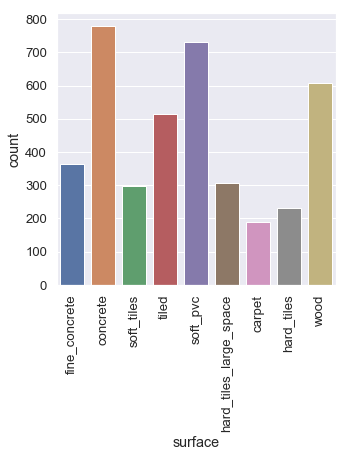

In [18]:
sns.set(style="whitegrid")
sns.set(font_scale=1.2)  
plt.figure(figsize=(5,5))
ax = sns.countplot(x="surface", data=y_timeseries)
plt.xticks(rotation=90)

### Extract features

In [19]:
import multiprocessing

In [22]:
n_jobs = multiprocessing.Semaphore(multiprocessing.cpu_count()) 
label = y.surface.unique()

In [16]:
from tsfresh import extract_features
extracted_features = extract_features(timeseries, column_id="series_id", column_sort="measurement_number", n_jobs = 8)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [30:01<00:00, 13.07s/it]


In [22]:
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)

 'angle_X__fft_coefficient__coeff_65__attr_"angle"'
 'angle_X__fft_coefficient__coeff_65__attr_"imag"' ...
 'orientation_Z__fft_coefficient__coeff_99__attr_"angle"'
 'orientation_Z__fft_coefficient__coeff_99__attr_"imag"'
 'orientation_Z__fft_coefficient__coeff_99__attr_"real"'] did not have any finite values. Filling with zeros.


variable,angle_X__abs_energy,angle_X__absolute_sum_of_changes,"angle_X__agg_autocorrelation__f_agg_""mean""__maxlag_40","angle_X__agg_autocorrelation__f_agg_""median""__maxlag_40","angle_X__agg_autocorrelation__f_agg_""var""__maxlag_40","angle_X__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","angle_X__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","angle_X__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","angle_X__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","angle_X__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,orientation_Z__symmetry_looking__r_0.9,orientation_Z__symmetry_looking__r_0.9500000000000001,orientation_Z__time_reversal_asymmetry_statistic__lag_1,orientation_Z__time_reversal_asymmetry_statistic__lag_2,orientation_Z__time_reversal_asymmetry_statistic__lag_3,orientation_Z__value_count__value_-1,orientation_Z__value_count__value_0,orientation_Z__value_count__value_1,orientation_Z__variance,orientation_Z__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,1033.658119,0.014299,-0.055278,-0.287831,0.352127,2.843056,-0.563704,-0.000154,0.000068,2.843882,...,1.0,1.0,9.232210e-08,1.771012e-07,2.448321e-07,0.0,0.0,0.0,1.849946e-07,0.0
1,1032.490840,0.026968,-0.214779,-0.435811,0.411031,2.841002,-0.146772,-0.000040,0.000082,2.842194,...,1.0,1.0,3.939979e-08,8.375859e-08,1.317400e-07,0.0,0.0,0.0,2.562990e-07,0.0
2,1036.420318,0.016951,-0.061953,-0.293390,0.345428,2.845347,0.432342,0.000115,0.000072,2.847296,...,1.0,1.0,5.344816e-07,1.215204e-06,1.879632e-06,0.0,0.0,0.0,2.899262e-07,0.0
3,1036.602463,0.051115,-0.120510,-0.377385,0.366902,2.848673,-0.370552,-0.000290,0.000219,2.851495,...,1.0,1.0,1.611573e-08,4.055719e-08,6.052761e-08,0.0,0.0,0.0,2.001860e-07,0.0
4,1034.173141,0.013230,-0.165258,-0.436335,0.393251,2.842954,-0.132873,-0.000024,0.000053,2.843791,...,1.0,1.0,-3.940681e-07,-7.717491e-07,-1.133440e-06,0.0,0.0,0.0,9.632731e-07,0.0
5,1031.943274,0.030127,0.122826,-0.077240,0.188671,2.840669,-0.365410,-0.000100,0.000077,2.841008,...,1.0,1.0,-7.028719e-07,-1.188935e-06,-1.655273e-06,0.0,0.0,0.0,4.289354e-07,0.0
6,1033.465142,0.007615,0.530039,0.485455,0.065670,2.840361,0.891171,0.000226,0.000035,2.841116,...,1.0,1.0,5.593398e-07,1.120867e-06,1.600693e-06,0.0,0.0,0.0,1.002705e-07,0.0
7,1036.211782,0.036398,-0.092002,-0.331095,0.343503,2.846907,-0.269659,-0.000119,0.000128,2.847968,...,1.0,1.0,1.418325e-08,1.391160e-08,3.973860e-08,0.0,0.0,0.0,3.088928e-07,0.0
8,1036.080043,0.005020,0.623910,0.639490,0.051382,2.845701,-0.952349,-0.000091,0.000009,2.845811,...,1.0,1.0,-4.663800e-07,-9.265861e-07,-1.327047e-06,0.0,0.0,0.0,4.427986e-08,0.0


In [184]:
np.shape(impute(extracted_features))

(4021, 10322)

In [18]:
from tsfresh import select_features

In [105]:
relevant_features = set()

for label in y.surface.unique():
    y_train_binary = y_timeseries.surface == label
    y.surface_binary =  pd.DataFrame(data=y_train_binary).reset_index()
    X_train_filtered = select_features(extracted_features, y_train_binary)

    print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], extracted_features.shape[1]))
    relevant_features = relevant_features.union(set(X_train_filtered.columns))


Number of relevant features for class fine_concrete: 1117/10322


Number of relevant features for class concrete: 3042/10322


Number of relevant features for class soft_tiles: 3179/10322


Number of relevant features for class tiled: 3043/10322


Number of relevant features for class soft_pvc: 3022/10322


Number of relevant features for class hard_tiles_large_space: 3129/10322


Number of relevant features for class carpet: 1674/10322


Number of relevant features for class hard_tiles: 3338/10322


Number of relevant features for class wood: 3201/10322


In [195]:
X_filtered = extracted_features[list(relevant_features)]
X_filtered.to_csv('X_train_selected_features.csv')

In [153]:
for type_surface in y.surface.unique():
    print (type_surface, 'has', len(y[y['surface'] == type_surface].group_id.unique()), 'groups', \
            len(y[y['surface'] == type_surface].series_id.unique()), 'examples')

fine_concrete has 7 groups 363 examples
concrete has 15 groups 779 examples
soft_tiles has 6 groups 297 examples
tiled has 9 groups 514 examples
soft_pvc has 14 groups 732 examples
hard_tiles_large_space has 5 groups 308 examples
carpet has 4 groups 189 examples
hard_tiles has 1 groups 232 examples
wood has 12 groups 607 examples


In [138]:
y.groupby(['group_id', 'surface']).size().reset_index().groupby('surface')[[0]].max()


,0
surface,
carpet,71
concrete,70
fine_concrete,70
hard_tiles,232
hard_tiles_large_space,71
soft_pvc,71
soft_tiles,57
tiled,70
wood,70


In [181]:
testX_extracted_features = extract_features(testX, column_id="series_id", column_sort="measurement_number", n_jobs = 8)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 40/40 [28:14<00:00, 10.66s/it]


In [180]:
testX_comb = conv_euler_angles(testX)

testX['angle_X'] = testX_comb[:,:,10].ravel()
testX['angle_Y'] = testX_comb[:,:,11].ravel()
testX['angle_Z'] = testX_comb[:,:,12].ravel()

testX = testX.drop(['row_id'], axis=1)
testX.head()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,angle_X,angle_Y,angle_Z
0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,2.844733,-0.014254,3.091597
1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,2.844432,-0.014411,3.091804
2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,2.844239,-0.014658,3.091975
3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,2.844418,-0.014712,3.092085
4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100,2.844918,-0.014434,3.092079


In [180]:
testX_comb = conv_euler_angles(testX)

testX['angle_X'] = testX_comb[:,:,10].ravel()
testX['angle_Y'] = testX_comb[:,:,11].ravel()
testX['angle_Z'] = testX_comb[:,:,12].ravel()

testX = testX.drop(['row_id'], axis=1)
testX.head()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,angle_X,angle_Y,angle_Z
0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,2.844733,-0.014254,3.091597
1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,2.844432,-0.014411,3.091804
2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,2.844239,-0.014658,3.091975
3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,2.844418,-0.014712,3.092085
4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100,2.844918,-0.014434,3.092079


In [201]:
X_test_filtered = testX_extracted_features[list(relevant_features)]

In [224]:
X_test_filtered.to_csv('X_test_filtered.csv')

In [204]:
cl = ExtraTreesClassifier(n_estimators=70)
cl.fit(X_filtered, y_timeseries.surface)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [205]:
result = cl.predict(X_test_filtered)
result_pd = pd.DataFrame({'series_id': [i for i in range(len(result))], 'surface':result})
result_pd.to_csv('predict_from_selected_feature.csv', index = False)

# Submission score 0.65!

## Try fine tuning parameter using grid search

In [215]:
from sklearn.model_selection import GridSearchCV

In [217]:
parameters = {'bootstrap':('False', 'Ture'), 'max_depth':[10, 50, None]}
model = ExtraTreesClassifier(n_estimators=100, n_jobs = 8)
clf = GridSearchCV(model, parameters, cv = 2)
clf.fit(X_filtered.values,  y_timeseries.surface)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=8,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bootstrap': ('False', 'Ture'), 'max_depth': [10, 50, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [220]:
clf.cv_results_

c:\program files\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\program files\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\program files\python36\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\program files\python36\lib\site-packages\sklearn\ut

{'mean_fit_time': array([1.43370318, 1.51313484, 1.4991622 , 1.37021947, 1.49415874,
        1.47516894]),
 'std_fit_time': array([0.02449703, 0.03296745, 0.01600003, 0.01400208, 0.02798343,
        0.00699615]),
 'mean_score_time': array([0.0929476 , 0.09144902, 0.09195232, 0.08795083, 0.09344721,
        0.09394753]),
 'std_score_time': array([4.99594212e-03, 4.99963760e-04, 2.00295448e-03, 3.57627869e-07,
        1.49893761e-03, 3.57627869e-07]),
 'param_bootstrap': masked_array(data=['False', 'False', 'False', 'Ture', 'Ture', 'Ture'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[10, 50, None, 10, 50, None],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'bootstrap': 'False', 'max_depth': 10},
  {'bootstrap': 'False', 'max_depth': 50},
  {'bootstrap': 'False', 'max_depth': None},
  {'bootstrap': 

### conclusions: keep the max_depth to 50, bootstrap True

In [221]:
cl = ExtraTreesClassifier(n_estimators=70, bootstrap = True, max_depth = 50 )
cl.fit(X_filtered, y_timeseries.surface)

ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=50, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [222]:
result = cl.predict(X_test_filtered)
result_pd = pd.DataFrame({'series_id': [i for i in range(len(result))], 'surface':result})
result_pd.to_csv('predict_from_selected_feature_finetune1.csv', index = False)

## New score 0.66